This notebook will develop techniques for mapping LIBS spectra to line intensities
The observed Voigt peaks are the experimentally observed artifact of a line emission at precise energy
Almost all of the processing and fitting will be more direct with lines vs. peaks
Examples of pre-processing considered includes assessment of temperature based on relative line intensities (by el/ion state)
Moreover (at known temp) the line intensities are directly proportional to elemental/ionic concentration in the plasma

In [1]:
#reference paper is "continuous wavelet transform based automatic curve fitting method for LIBS, Yang 2018, Applied Optics"
#rather than start with wavelet transform, approach peak identification numerically
#If, at every point, we calculate the difference in intensity to adjacent points (before / after) we detect maxima
#In presence of noise more advanced technique needed, perhaps relative to average of min 2 of three point. (drop outlier)
#For simulated /smoothed spectra a simple approach should be sufficient

In [2]:
#imports and env
import numpy as np
import pickle
#import math
from scipy.special import voigt_profile as voigt
from scipy.optimize import least_squares
from matplotlib import pyplot as plt
import plotly.graph_objects as go

#needed to import our package from sibling directory
import os
import sys
sys.path.insert(0, os.path.abspath('../..'))
from libs_unet.training.spec_maker import spectrum_maker
from pathlib import Path

top_dir = Path.cwd().parent.parent #working directory for notebook should be location of notebook
rel_path = 'data' 
datapath = top_dir / rel_path

In [3]:
#create LIBS spectrum with indicated elemental fractions
spec_maker = spectrum_maker()
fracs_dict = {'Li':0.33, 'C':0.17, 'O':0.5}
wave, spec_dict, lines_dict = spec_maker.make_spectra(fracs_dict)
y_spec = spec_dict['comp']

In [93]:
wave[np.argmax(y_spec)]

671

<function matplotlib.pyplot.show(close=None, block=None)>

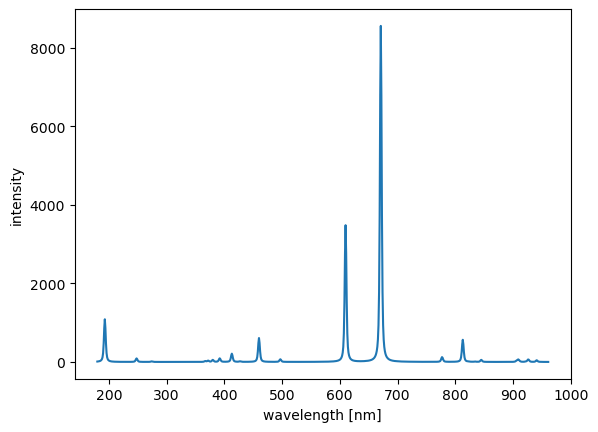

In [4]:
#Inspect LIBS spectrum
plt.plot(wave, y_spec) 
plt.xlabel('wavelength [nm]')   
plt.ylabel('intensity')
#plt.xlim([190, 950]) #note data may go beyond this range
plt.show

In [5]:
#next let's try peak identification, skip first and last points
peaks = np.zeros(len(wave)).astype('int')
for wl in range(len(wave)):
    if (wl ==0 or wl == len(wave)-1):
        pass
    elif (y_spec[wl] > y_spec[wl - 1] and y_spec[wl] > y_spec[wl + 1]):
        peaks[wl] = 1
    else:
        pass


In [6]:
#see how many peaks found
np.sum(peaks)

25

<function matplotlib.pyplot.show(close=None, block=None)>

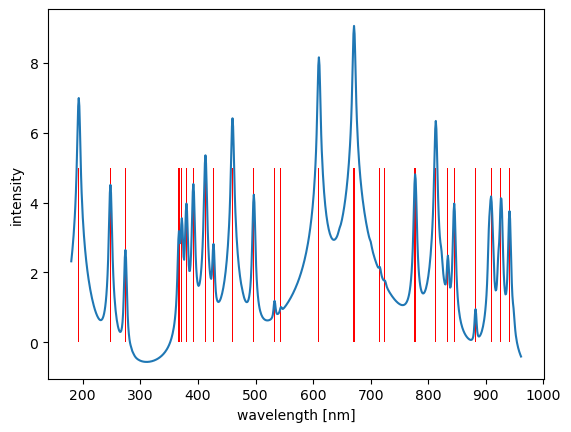

In [7]:
#plot peaks on spectrum, log int for vis, we see good unique peak detection
plt.plot(wave, np.log(y_spec+0.1)) 
plt.bar(x=wave, height = 5*peaks, width=2, color='red') #note width impacts line vis
plt.xlabel('wavelength [nm]')   
plt.ylabel('intensity')
plt.show

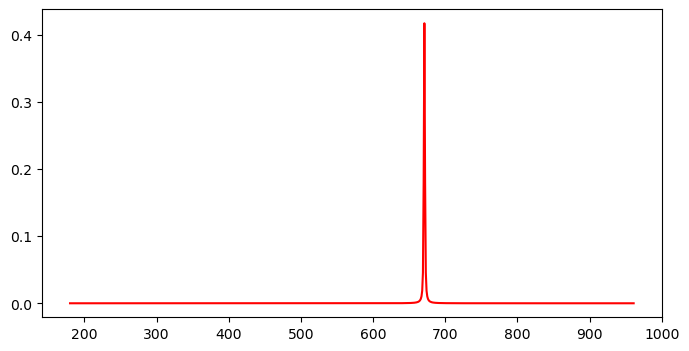

In [8]:
#first attempt a naive fit with voigt profiles at each peak location, solving for line intensities
#assert a fixed set of parameters based on the max intensity peak
fig, ax = plt.subplots(figsize=(8, 4))
peak_loc = 671
sigma = 0.5
gamma = 0.5
fit_profile = voigt(wave-peak_loc, sigma, gamma)
ax.plot(wave, fit_profile, color='red')

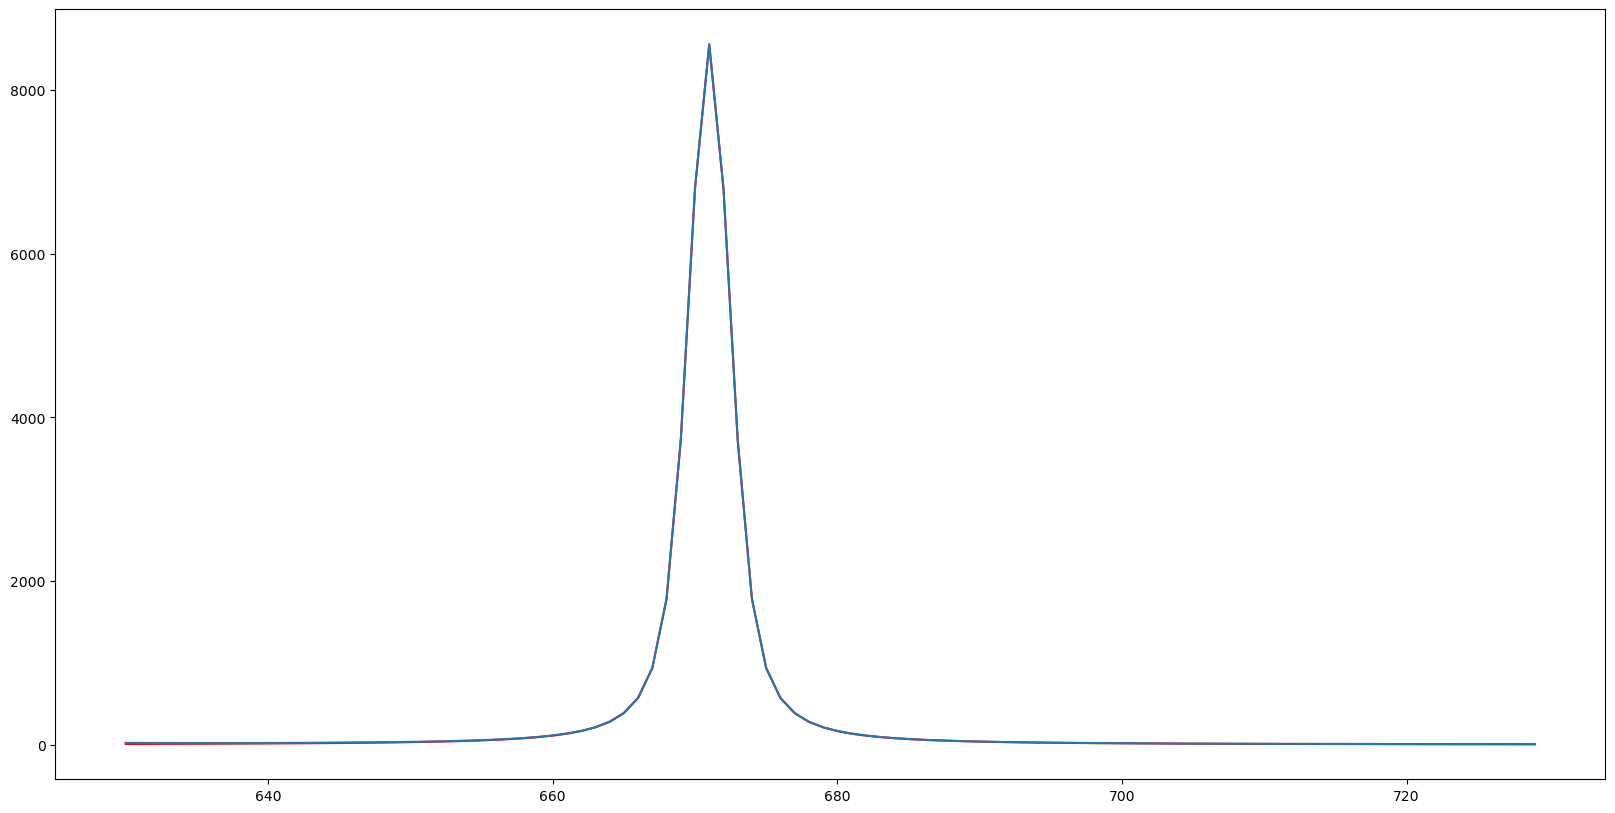

In [9]:
#now fit this over the spectrum, adjusting params to match shape/height
fig, ax = plt.subplots(figsize=(20, 10))
peak_loc = 671
sigma = 1
gamma = 1
fit_scale = 4.1e4
fit_profile = voigt(wave-peak_loc, sigma, gamma)
plt_mask = slice(450,550)
ax.plot(wave[plt_mask], fit_scale*fit_profile[plt_mask], color='red')
ax.plot(wave[plt_mask], y_spec[plt_mask])
#sigma and gamma =1 is basically perfect shape here. Params used to make spectra so makes sense
#TODO establish a fitting algorithm to fit these params

In [10]:
#we will use a least-squares approach to fit n=peaks voigt profiles
#independent variables are the n scale factors 
# scale equivalent to the atomic line intensities behind the spectrum

#first determine the wavelengths to center the profiles on
peak_loc = []
peak_height = []
for i in range(len(wave)):
    if peaks[i] == 1:
        peak_loc.append(wave[i])
        peak_height.append(y_spec[i])
peak_loc = np.asarray(peak_loc)
peak_height = np.asarray(peak_height)
shifts = np.ones((len(peak_loc), len(wave)))
shifts = shifts * wave
shifts = shifts - peak_loc[:,None]
profiles = voigt(shifts, sigma, gamma)
plots_x = shifts.copy()
plots_x[:] = wave


In [11]:
l_heights = np.random.random(len(peak_loc))
profiles = l_heights[:,None]*profiles

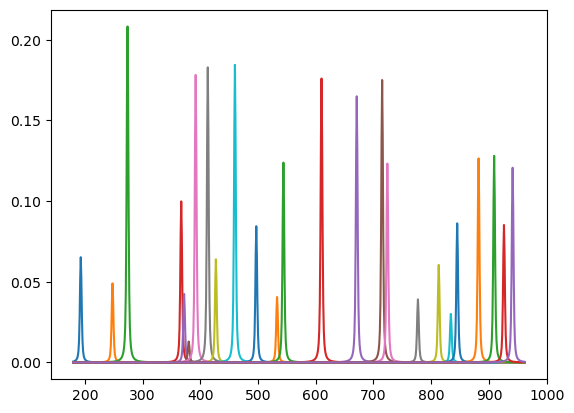

In [12]:
for x in range(len(profiles)):
    plt.plot(wave, profiles[x])
#confirmed this draws the curves at each peak loc with varying heights


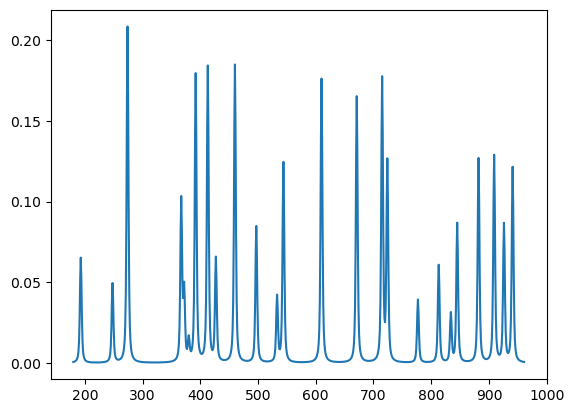

In [13]:
#confirm this correctly sums the voigt profiles
composite = np.sum(profiles, axis=0)
plt.plot(wave, composite)

In [14]:
np.max(composite - y_spec)
#this works, dim match

-0.4707785302330817

In [15]:
x0 = peak_height / np.sum(peak_height)
np.sum(x0)

1.0

In [16]:
#now we'll use the scikit least-squares algo to find the intensities that minimize error with these n peaks
#Try https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html

#define the residuals function (note algorithm squares for SSE)
def fun_fitspec(l_heights, shifts, y_spec):
    #calculate and sum
    return np.sum(l_heights[:,None] * voigt(shifts, sigma, gamma),axis=0) - y_spec

#weight bounds passed as a 2-tuple of vectors ([lower], [upper]) use np.inf for unbounded
#lower bound for all is non-negative weights
bnd_low = np.zeros(len(l_heights))
#upper bound is 1 (pure). must include small delta to zero to exclude, e.g. 0.0001
bnd_up = 20 * np.max(y_spec) * np.ones(len(l_heights))
h_bounds = (bnd_low, bnd_up)
#Initial guess at line heights is proportional to peak heights
x0 = peak_height / np.sum(peak_height)

#use the following form to run the LS min for a given input_spec of shape 
line_fit = least_squares(fun_fitspec, x0, args=(shifts, y_spec), bounds=h_bounds)

In [17]:
fit_heights = line_fit.x.copy()
fit_heights

array([5.20540392e+03, 4.29952951e+02, 6.37725642e+01, 9.92361002e+01,
       1.49165206e+02, 2.40781176e+02, 4.34606003e+02, 1.00403451e+03,
       6.46135773e+01, 2.91174307e+03, 3.19534884e+02, 6.12513324e+00,
       1.75347962e+00, 1.66749676e+04, 4.10059585e+04, 6.25364379e+00,
       2.82697300e+00, 5.91601361e+02, 2.69869573e+03, 4.14953085e+01,
       2.46117614e+02, 8.30909004e+00, 3.59418081e+02, 3.16526607e+02,
       2.01078030e+02])

<BarContainer object of 25 artists>

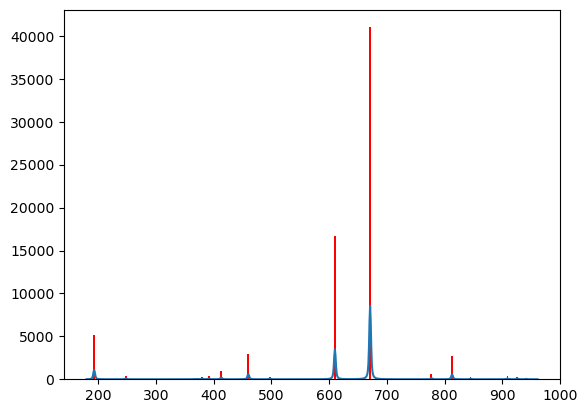

In [18]:
#Now plot the fit heights on top of the input spectrum
plt.plot(wave, y_spec)
plt.bar(peak_loc,fit_heights,color='red',width=3)

In [19]:
#In end state, we'll use these lines and relative heights to determine ion emissions at specific temps.
#Lab has found better experimental fit allowing for varying plasma temps.
#For given element, ionization states are f(Temp) and see different relative wl emissions based on temp
#With a function to produce lines as function of weighted element tuples of (ion, temp)
#That could be single step fit as min[spec - w(scale)*Sum(emission(ion(i,T(i))))]

In [20]:
#For our simulated spectra we ran at default NIST LIBs temp/condition and rolled up lines by element
#So this is simplified fitting for the simulated spectra as proof of concept
lines_file = "nist_elem_libs.pickle"
#create element list for this data file
with open(datapath / 'nist_libs' /lines_file, 'rb') as f:
    wave = pickle.load(f)
    atom_lines = pickle.load(f)
avail_elem = [key for key in atom_lines.keys()]
el_index = {} #lookup from el symb to array index of element
ind = 0
for el in avail_elem:
    el_index[el] = ind
    ind += 1

In [21]:
type(atom_lines['Li'])

numpy.ndarray

In [22]:
# atom lines is a dict so need to put this into an array for weighted multiplication by elemental composition variables
# will have a separate weight(first element) for scaling. Elements bounded [0,1] and will rescale to sum 1 after convergence
el_lines = np.zeros((len(avail_elem),len(wave)))
i = 0
for el in avail_elem:
    el_lines[i] = atom_lines[el]
    i += 1

In [23]:
#create a full wavelength format of the fit lines from above based on peak_loc, fit_heights
y_lines = np.zeros(len(wave))
wl_offset = wave[0] #subtract from actual wavelength to get index in wave array
i = 0
for peak in peak_loc:
    y_lines[peak - wl_offset] = fit_heights[i]
    i += 1

In [24]:
#define the residuals function (note algorithm squares for SSE)
def fun_fitlines(fit_wts, el_lines, y_lines):
    #calculate and sum
    return fit_wts[0] * np.sum(fit_wts[1:,None] * el_lines, axis=0) - y_lines

#Initial guess at line heights is proportional 1/n
x0 = np.zeros(len(avail_elem)+1)
x0[0] = 1e4
x0[1:] = (1/len(avail_elem)) * np.ones(len(avail_elem))

#weight bounds passed as a 2-tuple of vectors ([lower], [upper]) use np.inf for unbounded
#lower bound for all is non-negative weights
bnd_low = np.zeros(len(x0))
#upper bound is 1 (pure). must include small delta to zero to exclude, e.g. 0.0001
bnd_up = np.ones(len(x0))
bnd_up[0] = 1e6 #figure a practical upper scaling bound based on equipment?
h_bounds = (bnd_low, bnd_up)

#run the LS min
comp_fit = least_squares(fun_fitlines, x0, args=(el_lines, y_lines), bounds=h_bounds)

In [25]:
fit_wts = comp_fit.x.copy()
fit_wts

array([7.90732659e+00, 2.75726064e-07, 3.15062490e-07, 4.17351699e-02,
       6.00352015e-14, 1.89483272e-11, 2.15100719e-02, 8.14518287e-27,
       7.03968362e-02, 3.12853612e-10, 4.84093472e-08, 5.17510997e-22,
       6.69153877e-17, 1.52210477e-15, 2.16707184e-16, 2.97981471e-12,
       3.33624632e-08, 1.25391401e-04, 4.11742286e-18, 2.85652711e-09,
       1.08052430e-23, 8.78255667e-14, 5.86623340e-15, 3.07244485e-16,
       2.65771670e-21, 6.00032360e-18, 1.57497597e-17, 1.27825445e-14,
       6.74073210e-14, 4.15057474e-12, 1.91591967e-12, 6.90492894e-10,
       2.26775041e-10, 1.10490195e-09, 7.07099985e-40, 8.46305066e-17,
       3.49047104e-09, 1.89524759e-14, 4.90600697e-14, 2.77467622e-10,
       1.37534238e-12, 7.56224088e-12, 1.45402321e-09, 1.39626834e-12,
       2.48027126e-11, 2.32002712e-15, 1.08100863e-13, 2.78511021e-12,
       7.03111619e-25, 2.02564939e-11, 8.97924004e-10, 2.74163844e-08,
       5.58671260e-31, 5.63568184e-09, 3.09885452e-25, 1.89517371e-18,
      

In [26]:
el_arr = np.array(avail_elem)

In [27]:
el_arr[fit_wts[1:] > 0.01]

array(['Li', 'C', 'O'], dtype='<U2')

In [28]:
raw_wt = np.sum(fit_wts[1:])
raw_wt

0.13376831481860543

In [29]:
fit_wts[0] = fit_wts[0] * raw_wt
fit_wts[1:] = fit_wts[1:] / raw_wt

In [30]:
#apply threshold
min_wt = 0.01
fit_wts[1:][fit_wts[1:] < min_wt] = 0

In [31]:
#rescale last time
sum_wts = np.sum(fit_wts[1:])
fit_wts[0] = fit_wts[0] * sum_wts
fit_wts[1:] = fit_wts[1:] / sum_wts

In [32]:
#Results
i = 1
for el in avail_elem:
    if fit_wts[i] > 0:
        print(f"{el}: {fit_wts[i]}")
    i += 1

Li: 0.31229063901083104
C: 0.1609528389151623
O: 0.5267565220740066


In [33]:
np.sum(fit_wts[1:])

1.0

In [34]:
#compare to inputs to spectral simulation
print(fracs_dict)

{'Li': 0.33, 'C': 0.17, 'O': 0.5}


In [48]:
#expect this to be too noisy  with simple peak finding, but try fitting experimental Li2CO3 peak from LIBS
#this spectrum is saturated at 671 peak
filepath = "experimental/LIBS_Li2CO3.csv"
#filepath = "experimental/TLC_10-13-22/95-Test #95 17 29, Oct 13 2022.10.13.17.29.csv"
libs_spec = np.genfromtxt(datapath / filepath, delimiter=',', skip_header=1)
#will need to resample to our model specs for wavelength resolution
libs_wave = libs_spec[:,0]
libs_intens = libs_spec[:,1]

<function matplotlib.pyplot.show(close=None, block=None)>

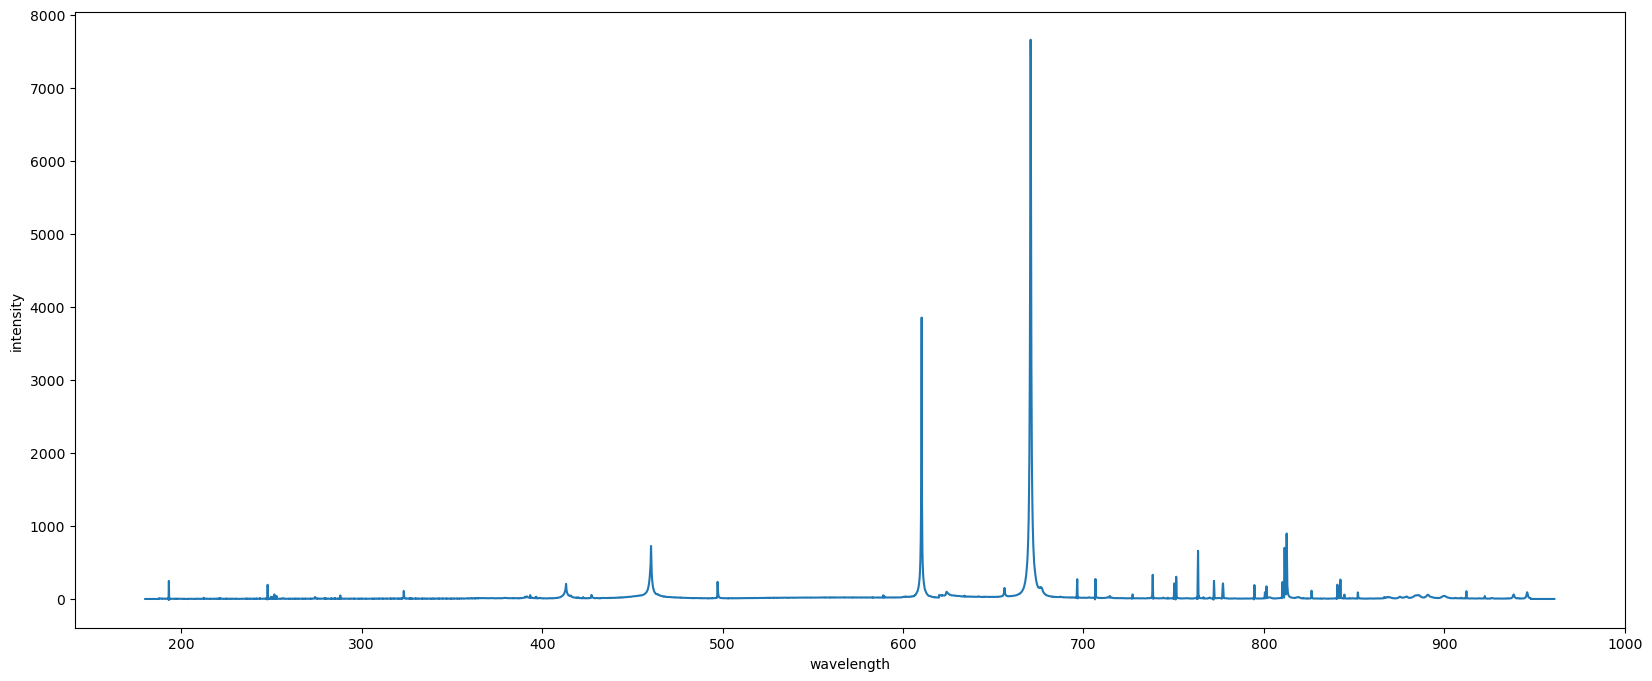

In [49]:
#Review experimental Li2CO3 spectrum plot
plt.figure(figsize=(20,8))
plt.plot(libs_wave, libs_intens)
plt.xlabel('wavelength')
plt.ylabel('intensity')
plt.show # Looks properly scaled

In [72]:
#Build a class for library that provides spectrum in -> composition out function

class peaks_fitter():
    #Class variables, access with self.var but do not modify else instance self.var "masks" class var
    lines_file = "nist_libs_hi_res.pickle"
    #lines_file = "nist_elem_libs.pickle"
    #create element list for this data file
    with open(datapath / 'nist_libs' /lines_file, 'rb') as f:
        ref_wave = pickle.load(f)
        atom_lines = pickle.load(f)
    avail_elem = [key for key in atom_lines.keys()]
    el_index = {} #lookup from el symb to array index of element
    ind = 0
    for el in avail_elem:
        el_index[el] = ind
        ind += 1
    #array representation of elemental line intensities
    el_lines = np.zeros((len(avail_elem),len(ref_wave)))
    i = 0
    for el in avail_elem:
        el_lines[i] = atom_lines[el]
        i += 1

    def __init__(self) -> None:
        super().__init__()
        #TODO determine if reference wave/int data passed or global as now

    #define the residuals function for line heights at peaks (note algorithm squares for SSE)
    def fun_fitspec(self, l_heights, shifts, y_spec, sigma, gamma):
        #calculate and sum
        return np.sum(l_heights[:,None] * voigt(shifts, sigma, gamma),axis=0) - y_spec

    #define the residuals function for element weights to fit spectral lines
    def fun_fitlines(self, fit_wts, el_lines, y_lines):
        #calculate and sum
        return fit_wts[0] * np.sum(fit_wts[1:,None] * el_lines, axis=0) - y_lines

    def find_peaks(self, libs_wave, libs_intens, n_samp=10, cutoff=0.95):
        #resample input spec to supported range/resolution for model
        #assume even spacing monotonic nanometer wavelength grid
        wl_min = self.ref_wave[0]
        wl_inc = self.ref_wave[1] - self.ref_wave[0]
        wl_max = self.ref_wave[-1]
        resamp_spec = np.zeros(len(self.ref_wave))
    
        #Our reference builds from wl_min in increments of wl_inc. Put exp wl on this index
        for i in range(len(libs_wave)):
            #ensure exp wl in modeled range
            if libs_wave[i] < wl_min or libs_wave[i] > wl_max:
                continue
            #find index of nearest reference wl. put intensity there
            else:
                wl_ind = np.round((libs_wave[i] - wl_min)/wl_inc, 0).astype('int')
                resamp_spec[wl_ind] += libs_intens[i]

        #with resamp_spec as resampled spectrum aligned with ref_wave, proceed with peak find/fit
        #to smooth peak finding and avoid noise average the point with n_samp pre/post.
        #so we're going to shrink the experimental range by n_samp point on each side of spectra
        #zero out these skipped points in the array of averages (match ref_spec size)
        avg_spec = np.zeros(len(self.ref_wave))
        for i in range(len(resamp_spec)):
            if i < n_samp or i >= (len(resamp_spec) - n_samp):
                continue
            else:
                avg_spec[i] = np.average(resamp_spec[(i-n_samp):(i+n_samp+1)])#numpy slice excludes endpoint
                
        #limit peak finding to > cutoff quantile of peak intensities
        min_peak = np.quantile(resamp_spec, cutoff)
        #peak identification based on averages, skip first and last points
        peaks = np.zeros(len(self.ref_wave)).astype('int')
        for wl_ind in range(len(self.ref_wave)):
            if (wl_ind == 0 or wl_ind == len(self.ref_wave)-1) or resamp_spec[wl_ind] < min_peak:
                continue
            elif (avg_spec[wl_ind] > avg_spec[wl_ind - 1] and avg_spec[wl_ind] > avg_spec[wl_ind + 1]):
                peaks[wl_ind] = 1
            else:
                continue

        #determine the wavelengths to center the profiles on
        peak_loc = np.zeros(np.sum(peaks)) #peaks is full wl array with 1 indicating peak
        peak_height = np.zeros(np.sum(peaks))
        j = 0
        for i in range(len(self.ref_wave)):
            if peaks[i] == 1:
                peak_loc[j] = self.ref_wave[i]
                peak_height[j] = resamp_spec[i] #note: not avg, actual peak val
                j += 1
                
        return self.ref_wave, resamp_spec, peak_loc, peak_height, avg_spec
        

    def fit_peaks(self, libs_wave, libs_intens, sigma=1, gamma=1, min_wt=0.01):
        
        resamp_spec, peak_loc, peak_height = self.find_peaks(libs_wave, libs_intens)
        
        shifts = np.ones((len(peak_loc), len(self.ref_wave)))
        shifts = shifts * self.ref_wave
        shifts = shifts - peak_loc[:,None] #for each of n peaks, array of peak-centered wl offsets
        
        #L-S fit to find Line heights at peak locations that best fit input spec
        #weight bounds passed as a 2-tuple of vectors ([lower], [upper]) use np.inf for unbounded
        #lower bound for all is non-negative weights
        bnd_low = np.zeros(len(peak_height))
        #Upper bound needs to be bigger than max peak (lines integrated)
        bnd_up = 1e3 * np.max(y_spec) * np.ones(len(peak_height))
        h_bounds = (bnd_low, bnd_up)
        #Initial guess at line heights is proportional to peak heights
        x0 = peak_height

        #use the following form to run the LS min for a given input_spec of shape 
        line_fit = least_squares(fun_fitspec, x0, args=(shifts, y_spec, sigma, gamma), bounds=h_bounds)
        #TODO check for intensity at max value
        fit_heights = line_fit.x.copy()

        #create a full wavelength format of the fit lines from above based on peak_loc, fit_heights
        y_lines = np.zeros(len(wave))
        wl_offset = wave[0] #subtract from actual wavelength to get index in wave array
        i = 0
        for peak in peak_loc:
            y_lines[peak - wl_offset] = fit_heights[i]
            i += 1

        #Initial guess at element weights is proportional 1/n
        x0 = np.zeros(len(avail_elem)+1) #add a weight for scaling factor
        x0[0] = 1e4
        x0[1:] = (1/len(avail_elem)) * np.ones(len(avail_elem))

        #weight bounds passed as a 2-tuple of vectors ([lower], [upper]) use np.inf for unbounded
        #lower bound for all is non-negative weights
        bnd_low = np.zeros(len(x0))
        #upper bound is 1. Note: need a small delta if aim to exclude min=0, max = 1e-4
        bnd_up = np.ones(len(x0))
        bnd_up[0] = 1e6 #figure a practical upper scaling bound based on equipment?
        h_bounds = (bnd_low, bnd_up)

        #run the LS min
        el_fit = least_squares(fun_fitlines, x0, args=(el_lines, y_lines), bounds=h_bounds)
        fit_wts = el_fit.x.copy()

        #scale weights to sum to 1
        raw_wt = np.sum(fit_wts[1:])
        fit_wts[0] = fit_wts[0] * raw_wt #increase scale factor by divisor for weights, preserving overall spectral intensity
        fit_wts[1:] = fit_wts[1:] / raw_wt

        #apply a threshold factor based on % of total contributed intensity
        fit_wts[1:][fit_wts[1:] < min_wt] = 0
        #rescale again
        raw_wt = np.sum(fit_wts[1:])
        fit_wts[0] = fit_wts[0] * raw_wt #increase scale factor by divisor for weights, preserving overall spectral intensity
        fit_wts[1:] = fit_wts[1:] / raw_wt

        #create a results dict to return
        results = {}
        for i in range(1, len(fit_wts)):
            if fit_wts[i] > 0:
                results[avail_elem[i-1]] = fit_wts[i]
        
        return results
                
                                

In [81]:
#test peak finding
peak_fitter = peaks_fitter()
ref_wave, resamp_spec, peak_loc, peak_height, avg_spec = peak_fitter.find_peaks(libs_wave, libs_intens, n_samp=5, cutoff=0.9)

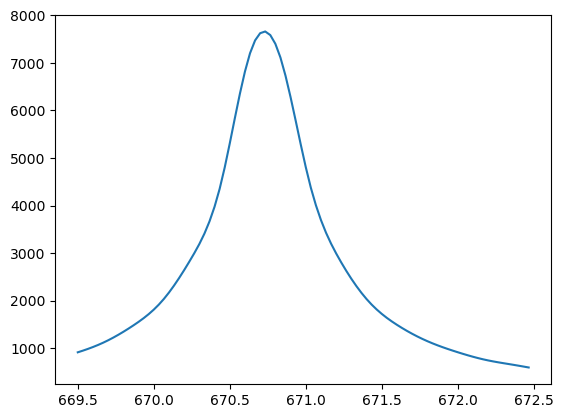

In [82]:
#li_mask = (np.round(libs_wave,0) == 670) | (np.round(libs_wave,0) == 671) | (np.round(libs_wave,0) == 672) #bitwise has precedence, need parens
li_mask = np.any([np.round(libs_wave,0) == 670, np.round(libs_wave,0) == 671, np.round(libs_wave,0) == 672],axis=0) #preferred
plt.plot(libs_wave[li_mask],libs_intens[li_mask])


14722
14722


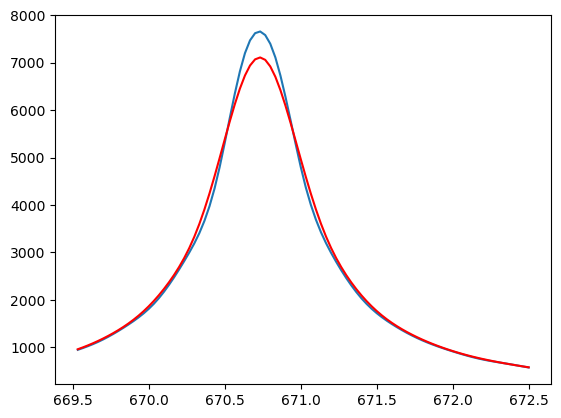

In [83]:
#look at what class had for avg vs. resampled
ref_mask = np.any([np.round(ref_wave,0) == 670, np.round(ref_wave,0) == 671, np.round(ref_wave,0) == 672],axis=0) #preferred
plt.plot(ref_wave[ref_mask], resamp_spec[ref_mask])
plt.plot(ref_wave[ref_mask], avg_spec[ref_mask], color = 'red')
print(np.argmax(resamp_spec))
print(np.argmax(avg_spec))

In [84]:
#so the indices align for avg max and actual max
#check peak_loc on this index vs. peak loc in spec
print(ref_wave[np.argmax(resamp_spec)])
print(peak_loc)

670.7328426001407
[193.0666536 247.8665988 288.1665585 323.2998567 393.33312   413.2331001
 415.8330975 427.3997526 453.3997266 453.9663927 454.7330586 460.2997197
 463.7997162 497.2663494 588.9662577 610.2995697 620.1662265 620.8662258
 621.4328919 622.0662246 624.1995558 626.1662205 627.332886  628.1662185
 629.1328842 629.8662168 630.3662163 630.7995492 634.1328792 656.2661904
 661.5995184 670.7328426 676.2328371 696.5328168 706.6994733 727.2661194
 738.3994416 750.3660963 751.4327619 763.4994165 772.3660743 777.2994027
 794.7993852 800.5993794 801.4660452 810.332703  811.4993685 812.6327007
 826.4326869 840.7993392 842.4326709 844.5993354 852.1326612 883.999296
 884.999295  885.4659612 885.9326274 890.8992891 899.7992802 912.2659344
 938.4325749 945.9659007]


In [85]:
len(peak_loc)

62

<BarContainer object of 28 artists>

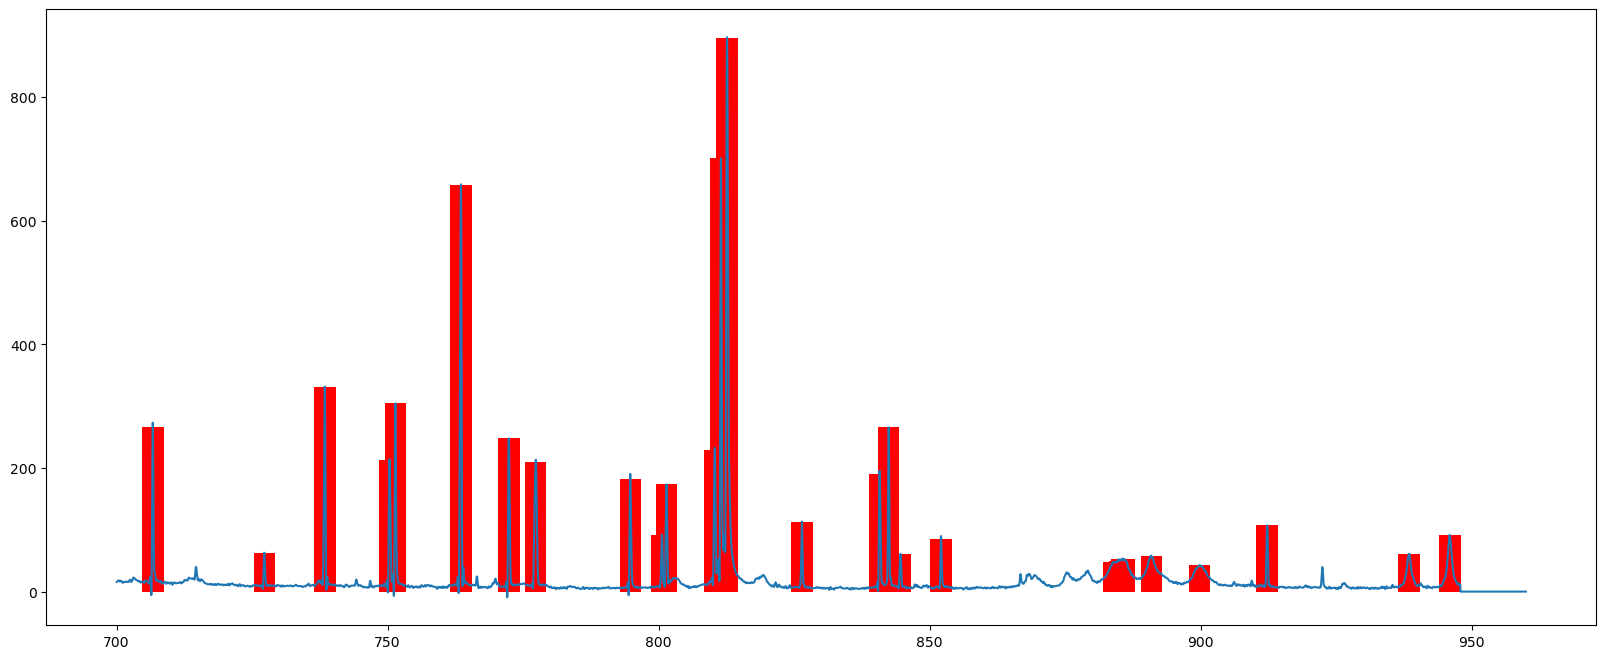

In [94]:
#plot the found peaks on the spectrum, mask by wl to zoom
#plot_mask = ref_wave > 0
#bar_mask = peak_loc >0
plot_mask = ref_wave > 700
bar_mask = peak_loc > 700
plt.figure(figsize=(20,8))
plt.plot(ref_wave[plot_mask], resamp_spec[plot_mask])
plt.bar(peak_loc[bar_mask], peak_height[bar_mask], color='red',width=4)

In [ ]:
#Determine why lines are left of peaks
max_spec_mask = libs_intens == np.max(libs_intens)
max_avg_mask = 

In [31]:
#Test class #DOES NOT CONVERGE
peak_fitter = peaks_fitter()
results = peak_fitter.fit_peaks(libs_wave, libs_intens)
#Think there are just too many weights with 23,000+ wavelength weights
#Maybe split into find peaks and find composition functions first to understand limitations
#The approach may be to focus on key lines for each element only, then check fit, subtract etc. 

KeyboardInterrupt: 

In [30]:
len(libs_wave)

23431

In [40]:
results

{'Li': 0.312290639096838, 'C': 0.16095283895867818, 'O': 0.5267565219444837}

In [41]:
#now try with experimental spectrum
results = peak_fitter.fit_peaks(libs_wave, libs_intens)

In [42]:
results #clearly a poor fit with a strong over-allocation to Fluorine

{'H': 0.041706004429927765,
 'Li': 0.0486387570163378,
 'N': 0.021050231601826168,
 'O': 0.07357690943755686,
 'F': 0.6437026793284581,
 'Cl': 0.010647108981563494,
 'Ar': 0.1606783092043297}

<BarContainer object of 782 artists>

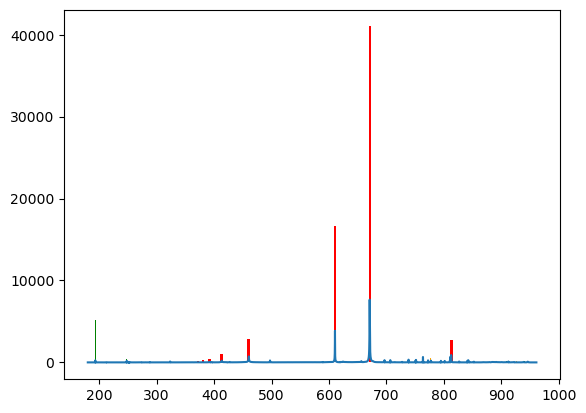

In [43]:
#chart the fluorine lines over experimental spec
plt.plot(libs_wave, libs_intens)
plt.bar(wave,0.33*atom_lines['Li'], color='red', width=4)
plt.bar(wave, 0.17*atom_lines['C'], color='green', width=2)
plt.bar(wave, 0.5*atom_lines['O'], color = 'orange')

<BarContainer object of 80 artists>

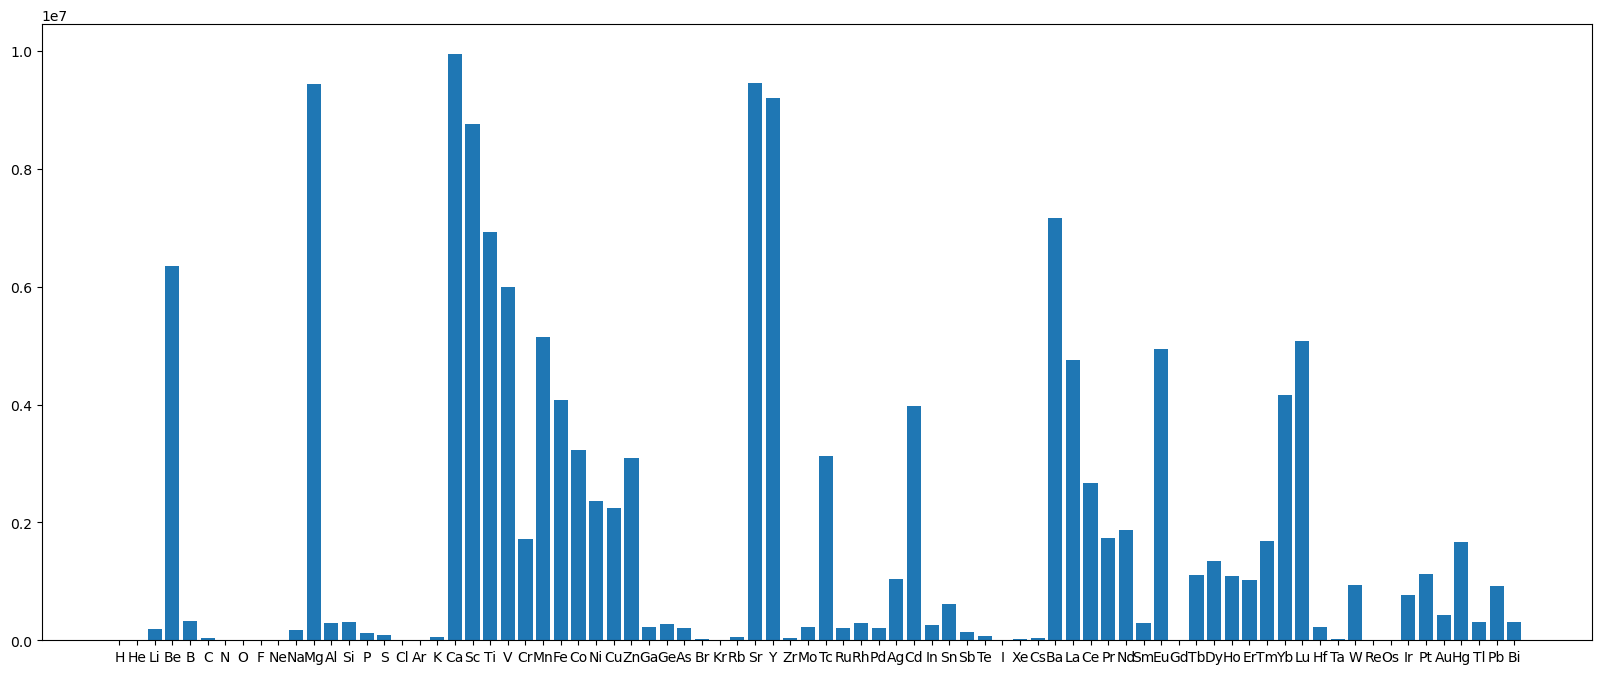

In [44]:
#calc total line intensity for each element
el_int = np.sum(el_lines, axis=1)
plt.figure(figsize=(20,8))
plt.bar(avail_elem,el_int)

Text(0.5, 1.0, 'Fluorine Lines')

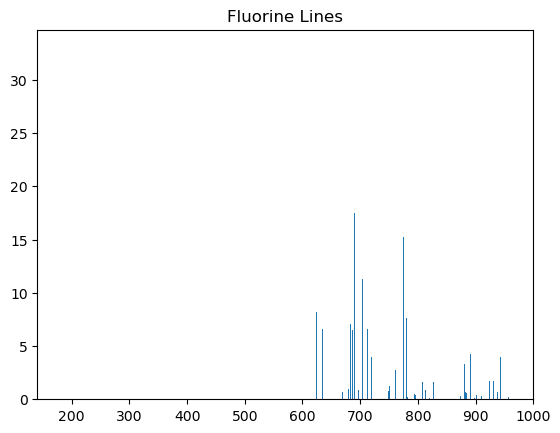

In [45]:
#Look at F lines
plt.bar(wave,atom_lines['F'])
plt.title("Fluorine Lines")

Text(0.5, 1.0, 'Li2CO3 (Li-orange, C-blue, O-red)')

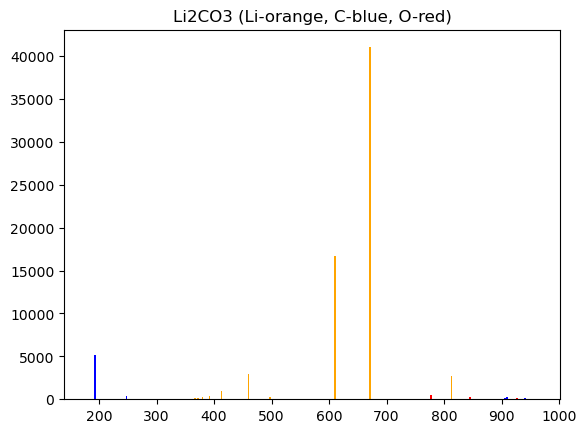

In [46]:
#There may be a fundamental scale issue. Look at simulated spec and corresponding lines scaled to same total intensity
#Look at relative line intensity for simulated Li2CO3
plt.bar(wave, 0.33*atom_lines['Li'], width=3,color='orange')
plt.bar(wave, 0.17*atom_lines['C'],width=3,color='blue')
plt.bar(wave, 0.5*atom_lines['O'],width=3,color='red')
plt.title("Li2CO3 (Li-orange, C-blue, O-red)")

In [47]:
# Noise will be a big problem in least squares fitting
# Loss functions will need to be enhanced
# Let's look at really penalizing the residual contributions from low-intensity el
el_int = np.sum(el_lines, axis=1)
print(np.min(el_int))
print(np.max(el_int))
res_scale = 1/el_int
res_scale = res_scale/np.min(res_scale)
res_scale = np.log(res_scale) + 1
print(np.min(res_scale))
print(np.max(res_scale))
#define the residuals function for element weights to fit spectral lines
def fun_fitlines(fit_wts, el_lines, y_lines):
    #calculate and sum
    return fit_wts[0] * np.sum(fit_wts[1:,None] * res_scale[:,None] * el_lines, axis=0) - y_lines

0.203631
9954230.330001112
1.0
18.704953924138486


In [48]:
#Test class
peak_fitter = peaks_fitter()
results = peak_fitter.fit_peaks(wave, y_spec)

In [49]:
results #so it's worse for our perfect fit case of simulation

{'Li': 0.43927951721491326, 'C': 0.16870844873111104, 'O': 0.3920120340539756}

In [50]:
#does this improve experimental spectrum?
results = peak_fitter.fit_peaks(libs_wave, libs_intens)
results#doesn't help, just shifts which low-intensity element gets allocation

{'H': 0.021963469519623923,
 'He': 0.5236518303509495,
 'Li': 0.04796972772322886,
 'N': 0.010779884045542129,
 'O': 0.038374546374414356,
 'F': 0.2746028462517791,
 'Ar': 0.08265769573446197}

0.0


(0.0, 1000000.0)

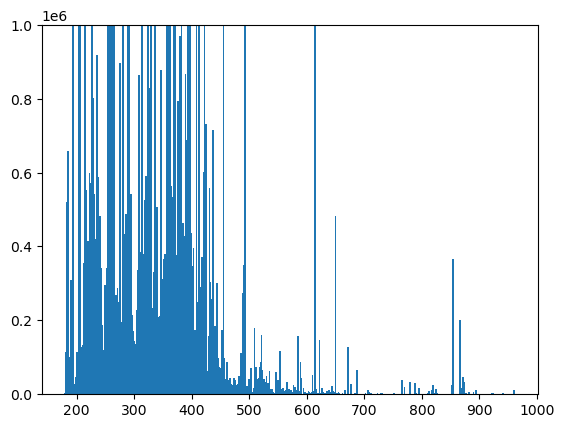

In [51]:
#Seems we should use the structure of what's available in terms of line sets to address noise
#All we can really tell from spectra is relative intensity/composition (?)
#Though it would be incredibly useful to be able to tell absolute composition from clear peaks (so we know how much more we seek)
#looking across elements, are their wavelengths we just don't expect to see line emissions at?
all_lines = np.sum(el_lines, axis=0)
print(np.min(all_lines))
plt.bar(wave,all_lines,width=3)
plt.ylim(0,1e6)

#plt.yscale('log')

0.1011017


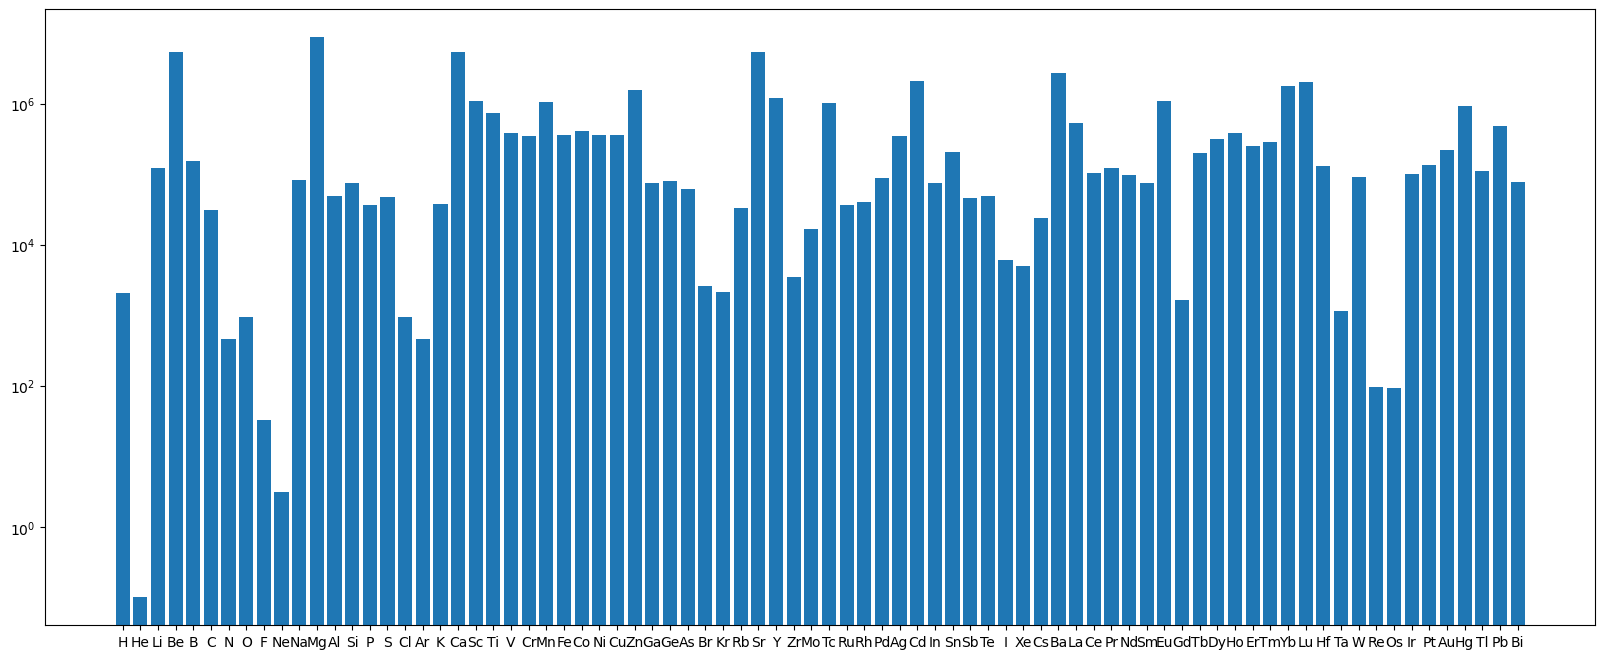

In [52]:
#Max line emission value by element
el_max = np.max(el_lines,axis=1)
print(np.min(el_max))
plt.figure(figsize=(20,8))
plt.bar(avail_elem,el_max)
plt.yscale('log')
#There is useful structure here. He isn't going to read on LIBS but Ne might and max line is ~4 orders < Li


In [53]:
all_lines[671-180]
#atom_lines['Li'][671-180]

127755.86600000133

In [54]:
#Experiment with elemental constraints. Only include elements that qualify somehow
#Initial idea is to use ratio of two biggest lines - element only included if this ratio within some bound
#However, we need to understand elements that overlap at certain energies and avoid those if possible.
#First visualize a specific element in context of all others - if primary peaks not interfered with then it's clear
#Going to "stack" the lines with different colors to ensure we don't mask
el_isolate = 'Li'
iso_el_ind = el_index[el_isolate]
el_others = all_lines.copy() - all_lines[iso_el_ind]

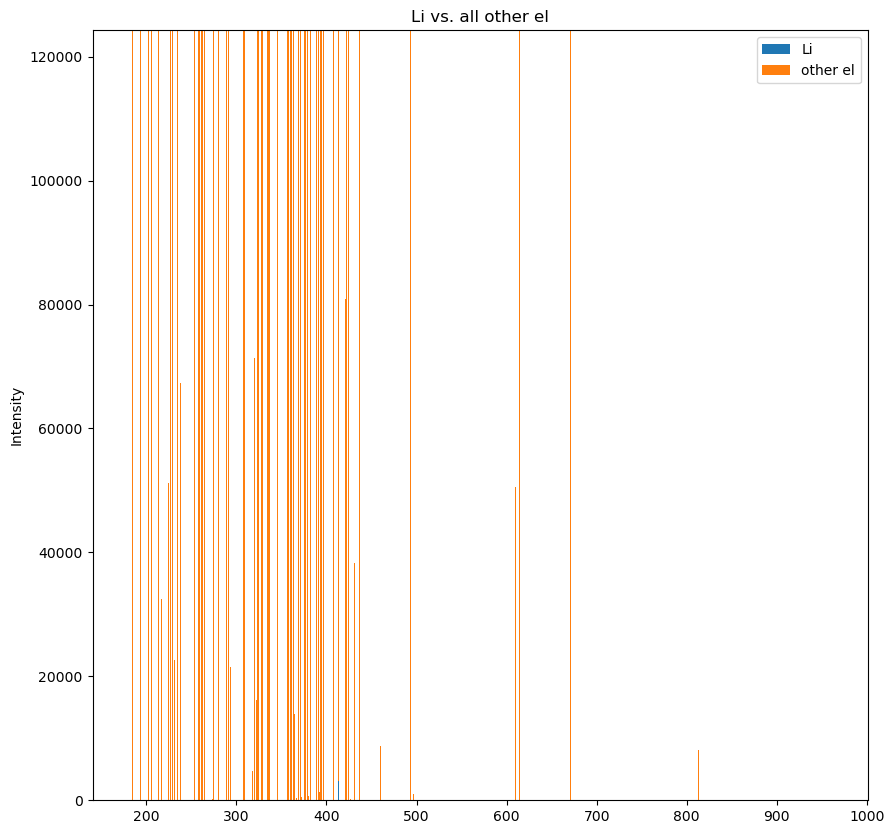

In [55]:
fig, ax = plt.subplots(figsize=(10,10))

ax.bar(wave, atom_lines[el_isolate], label=el_isolate, width=1)
ax.bar(wave, el_others,bottom=atom_lines[el_isolate], width=1, label='other el')
ax.set_ylim(0,np.max(atom_lines[el_isolate]))
ax.set_ylabel('Intensity')
ax.set_title(f'{el_isolate} vs. all other el')
ax.legend() #not too useful

In [56]:
#to find the "n greatest" efficiently we use argpartition
ex_arr = np.array([6,3,7,5,1,9])
#find smallest 2
print(np.argpartition(ex_arr,2)[:2]) #indices 4,1 are the smallest values (1 & 3)
#use negative indexing (from end of array) for max
print(np.argpartition(ex_arr,-2)[-2:]) #

[4 1]
[2 5]


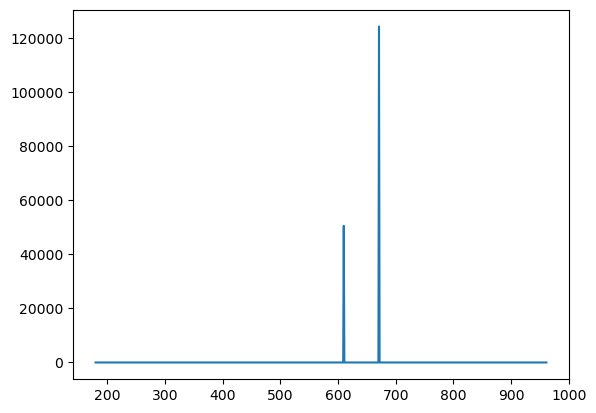

In [57]:
#Maybe better to do this on basis of numerical comparison
#Take two biggest peaks from focus element and compare to intensity from rest of elements
el_isolate = 'Li'
iso_el_ind = el_index[el_isolate]
el_others = all_lines.copy() - el_lines[iso_el_ind]
max_2ind = np.argpartition(el_lines[iso_el_ind],-2)[-2:]
el_iso_max2 = np.zeros(len(wave))
el_iso_max2[max_2ind] = el_lines[iso_el_ind][max_2ind]
plt.plot(wave,el_iso_max2)



In [58]:
line_interfere = el_others[max_2ind] / el_iso_max2[max_2ind]
line_interfere

array([0.0370352 , 0.02813348])

In [68]:
#Make a table of this data with relevant wavelengths for every element
#Each data row will contain [el_sym, wl_1, wl_1_int, wl1_pct_intfc, wl_2, wl_2_int,wl2_pct_intfc]
#plotly takes data in column form
el_col = []
wl1_col = []
wl1_int_col = []
wl1_pct_intfc = []
wl2_col = []
wl2_int_col =[]
wl2_pct_intfc = []
for el in avail_elem:
    el_col.append(el)
    #find the two max intensity wavelengths
    el_ind = el_index[el]
    max_2ind = np.argpartition(el_lines[el_ind],-2)[-2:]
    wl1_col.append(wave[max_2ind][0])
    wl2_col.append(wave[max_2ind][1])
    wl1_int_col.append(f'{el_lines[el_ind][max_2ind][0]:,.2f}')
    wl2_int_col.append(f'{el_lines[el_ind][max_2ind][1]:,.2f}')
    #get additive spectrum of all other lines without this element
    el_others = all_lines - el_lines[el_ind]
    line_intc = el_others[max_2ind] / el_lines[el_ind][max_2ind]
    wl1_pct_intfc.append(f'{line_intc[0]:.2f}')
    wl2_pct_intfc.append(f'{line_intc[1]:.2f}')

tab_head = ['Elem','Max WL1','WL1 Inten', 'WL1 Interf', 'Max WL2','WL2 Int','WL2 Interf']

fig = go.Figure(data=[go.Table(header=dict(values=tab_head),
        cells=dict(values=[el_col, wl1_col, wl1_int_col, wl1_pct_intfc, wl2_col, wl2_int_col, wl2_pct_intfc],align='right'))])

fig.update_layout(width=800, height=1900)
                    
fig.show()

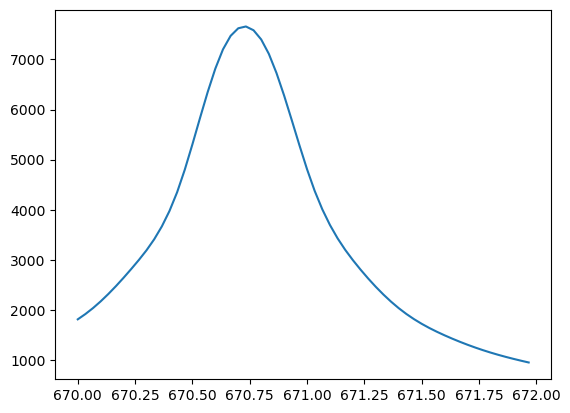

In [88]:
#what about higher resolution?, check out libs gun data around Li 671 peak
plt.plot(libs_wave[(libs_wave >670) & (libs_wave < 672)],libs_intens[(libs_wave >670) & (libs_wave < 672)])
#so yes the gun is resolving fine detail at this 0.03nm sampling frequency
#generate

In [6]:
#regenerate the simulated elemental data on a more precise 0.03 nm resolution and redo analysis above for top 2 lines by element
#Run imports cell
#This repeats / overwrites same code above from lower res

#For our simulated spectra we ran at default NIST LIBs temp/condition and rolled up lines by element
#So this is simplified fitting for the simulated spectra as proof of concept
lines_file = "nist_libs_hi_res.pickle"
#create element list for this data file
with open(datapath / 'nist_libs' /lines_file, 'rb') as f:
    wave = pickle.load(f)
    atom_lines = pickle.load(f)
avail_elem = [key for key in atom_lines.keys()]
el_index = {} #lookup from el symb to array index of element
ind = 0
for el in avail_elem:
    el_index[el] = ind
    ind += 1

#array representation of elemental line intensities
el_lines = np.zeros((len(avail_elem),len(wave)))
i = 0
for el in avail_elem:
    el_lines[i] = atom_lines[el]
    i += 1

In [8]:
wave[22]

180.7333326000002

In [9]:
#Make a table of this data with relevant wavelengths for every element
#Each data row will contain [el_sym, wl_1, wl_1_int, wl1_pct_intfc, wl_2, wl_2_int,wl2_pct_intfc]
#plotly takes data in column form
all_lines = np.sum(el_lines, axis=0)
el_col = []
wl1_col = []
wl1_int_col = []
wl1_pct_intfc = []
wl2_col = []
wl2_int_col =[]
wl2_pct_intfc = []
for el in avail_elem:
    el_col.append(el)
    #find the two max intensity wavelengths
    el_ind = el_index[el]
    max_2ind = np.argpartition(el_lines[el_ind],-2)[-2:]
    wl1_col.append(f'{wave[max_2ind][0]:,.2f}')
    wl2_col.append(f'{wave[max_2ind][1]:,.2f}')
    wl1_int_col.append(f'{el_lines[el_ind][max_2ind][0]:,.2f}')
    wl2_int_col.append(f'{el_lines[el_ind][max_2ind][1]:,.2f}')
    #get additive spectrum of all other lines without this element
    el_others = all_lines - el_lines[el_ind]
    line_intc = el_others[max_2ind] / el_lines[el_ind][max_2ind]
    wl1_pct_intfc.append(f'{line_intc[0]:.2f}')
    wl2_pct_intfc.append(f'{line_intc[1]:.2f}')

tab_head = ['Elem','Max WL1','WL1 Inten', 'WL1 Interf', 'Max WL2','WL2 Int','WL2 Interf']

fig = go.Figure(data=[go.Table(header=dict(values=tab_head),
        cells=dict(values=[el_col, wl1_col, wl1_int_col, wl1_pct_intfc, wl2_col, wl2_int_col, wl2_pct_intfc],align='right'))])

fig.update_layout(width=800, height=1900)
                    
fig.show()